TODO:
1. проверить переменные на выбросы и выбросить их если есть
2. Проверить какие параметры реально важны для модели
3. ОФОРМИТЬ

Решение задачи прогнозирования стоимости авто по параметрам.

Нужно:

1. EDA. Проверить данные в тестовой выборке.
2. Собрать новые данные спарсив их с сайта автору.
3. Построить модель.

In [1]:
# Импортируем необходимые библиотеки:
from google.colab import files
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error

In [2]:
#функция получения boxplot для колонки. На вход наименование колонки. Универсальную не делал
def get_box_plot(column):
  fig, ax = plt.subplots(1,1, figsize = (30,10))
  sns.set_style("whitegrid")
  box_plot = sns.boxplot(x=column,y="price",data=result[result['price']>0])

  medians = result.groupby([column])['price'].median()
  vertical_offset = result[result['price']>0]['price'].median() * 0.05 # offset from median for display

  for xtick in box_plot.get_xticks():
      box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
              horizontalalignment='center',size='x-small',color='w',weight='semibold')
      

#функция чтобы вычеслить MAPE
def mape(Y_actual,Y_Predicted):
    #Reshape для того чтобы сравнить выборки друг с другом
    new_len = len(Y_Predicted)
    Y_Predicted=Y_Predicted.reshape(new_len,1)

    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

**EDA**

Посмотрим на данные на которых нужно обучить модель. Парсинг и небольшая обработка в отдельном файле.

In [3]:
#тестовая выборка есть в задании
path = "/content/drive/My Drive/Colab Notebooks/car_price/test.csv"
test = pd.read_csv(path, sep=',')

#обучающую спарсил отдельно
path = "/content/drive/My Drive/Colab Notebooks/car_price/train.csv"
train = pd.read_csv(path, sep=',')

test.head(3)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


Описание полей:

* bodyType - тип кузова
* brand - производитель
* car_url - ссылка на объявление
* color - цвет авто
* engineDisplacement 	- объём двигателя?
* enginePower - мощность в лошадиных силах?
* fuelType - тип топлива 
* image - ссылка на фото
* mileage - пробег
* model_name - название модели
* name - объём двигателя, турбина, кол-во ЛС
* numberOfDoors - кол-во дверей 
* productionDate - год производства авто
* sell_id - ID продавца или объявления?
* vehicleTransmission - тип кпп
* vendor - регион производителя. В выборке только EUROPEAN и JAPANESE
* Владельцы - кол-во владельцев
* Владение - длительность во владении в годах и месяцах на русском
* ПТС - оригинал или дубликат
* Привод - тип привода
* Руль - расположение руля
* Состояние - состояние авто
* Таможня - требуется ли растамаживать

Список полей, которые сразу можно удалять:
* description описание - текстовое описание. Могли бы из него вытащить состояние и тд, но оно нам не нужно тк эта информация есть в отдельных колонках.
* model_info - информация о модели, название на русском и тд. Тоже обойдёмся без этого справочника.
* super_gen - описание кол-ва ЛС, типа привода, типа топлива, расхода и ускорения. Вся эта информация есть в отдельных полях.
* vehicleConfiguration - тип кузова и объём двигателя. Тоже дублируется в других полях.
* priceCurrency - валюта цены. Везде рубли, можно удалить.
* parsing_unixtime - время когда парсили

Под вопросом данные из полей:
* complectation_dict - словарь с названием комплектации авто установленными опциями(не путать с функциями в авто)
* equipment_dict - функции авто, словарь. Лежит на странице объявления в блоке "Комплектация"
* modelDate - год выпуска модели(не авто а всего модельного ряда)

Переименуем русскоязычные колонки которые планируем использовать в eng для удобной работы

In [4]:
test.rename(columns={'Владельцы': 'owners', 'ПТС': 'pts',
       'Привод': 'gear_type', 'Руль': 'steering_wheel'}, inplace=True)

In [5]:
set(test.columns).difference(train.columns)

{'car_url',
 'complectation_dict',
 'description',
 'equipment_dict',
 'image',
 'modelDate',
 'model_info',
 'model_name',
 'name',
 'parsing_unixtime',
 'priceCurrency',
 'super_gen',
 'vehicleConfiguration',
 'Владение',
 'Состояние',
 'Таможня'}

Удалим то что отличается в датасетах и то что не планируем использовать

In [6]:
#Удалим колонки, которые не можем проанализировать или которые дублируют информацию
coll_to_drop = ['car_url', 'complectation_dict', 'description', 'model_info', 
                'equipment_dict', 'image', 'modelDate', 'name', 'parsing_unixtime',
                'super_gen', 'vehicleConfiguration', 'priceCurrency',
                'model_name', 'Владение', 'Состояние', 'Таможня']

#удалим не нужные колонки посмотрим на остальные 
test.drop(labels=coll_to_drop, axis=1, inplace=True)

Добавляем колонку price в тестовый датасет, по ней и будем понимать что есть тест. В трейне прайс не нулевой.

In [7]:
test['price']=0

Объединяем датасет для дальнейшей работы

In [8]:
ds = [test, train]
result = pd.concat(ds)
result.head(1)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,numberOfDoors,productionDate,sell_id,vehicleTransmission,vendor,owners,pts,gear_type,steering_wheel,price
0,лифтбек,SKODA,синий,1.2 LTR,105 N12,бензин,74000,5,2014,1100575026,роботизированная,EUROPEAN,3 или более,Оригинал,передний,Левый,0


Посмотрим на данные по ближе:

In [9]:
#сперва подсчитаем кол-во записей в тесте для статистики ниже
total_cnt = result.sell_id.count()

#пройдём по каждой колонке, посмотрим сколько уникальных, сколько не пустых, какой процест и выведем ТОП 15 популярных значений
for col in result.columns:
  non_nan = result[col].isna().sum()
  print('Колонка:', col)
  print('Не пустых:', total_cnt-non_nan, '. % заполненных данных', 100-(non_nan/total_cnt)*100)
  print('Уникальных значений:', result[col].nunique())
  display(result[col].value_counts().nlargest(15))
  print()


Колонка: bodyType
Не пустых: 117370 . % заполненных данных 100.0
Уникальных значений: 28


внедорожник             43314
седан                   35386
внедорожник 5 дв.       12228
лифтбек                  8323
хэтчбек                  4351
минивэн                  2370
универсал                2159
хэтчбек 5 дв.            2124
купе                     1882
компактвэн               1638
универсал 5 дв.          1276
пикап                     489
хэтчбек 3 дв.             485
пикап двойная кабина      280
купе-хардтоп              261
Name: bodyType, dtype: int64


Колонка: brand
Не пустых: 117370 . % заполненных данных 100.0
Уникальных значений: 12


VOLKSWAGEN    11529
MERCEDES      11424
NISSAN        11295
BMW           11211
TOYOTA        11113
AUDI          10343
MITSUBISHI    10084
SKODA         10060
VOLVO          8778
HONDA          8598
LEXUS          8156
INFINITI       4779
Name: brand, dtype: int64


Колонка: color
Не пустых: 117370 . % заполненных данных 100.0
Уникальных значений: 32


black          22607
white          19622
gray           12267
чёрный         11010
blue            7636
silver          7313
белый           6133
серебристый     4113
серый           3984
red             3850
brown           3719
синий           3289
green           1754
красный         1531
коричневый      1501
Name: color, dtype: int64


Колонка: engineDisplacement
Не пустых: 117370 . % заполненных данных 100.0
Уникальных значений: 454


2.0 LTR    7391
1598       6840
1998       5990
1.6 LTR    4973
1997       4365
1984       4018
3.0 LTR    3915
1969       3725
1.8 LTR    3349
1395       3058
1968       2719
3456       2502
2.5 LTR    2477
2993       2222
1995       1851
Name: engineDisplacement, dtype: int64


Колонка: enginePower
Не пустых: 117370 . % заполненных данных 100.0
Уникальных значений: 648


150        7953
249        7622
110        3663
190        2763
146        1875
140        1810
249 N12    1708
150 N12    1699
238        1586
105        1575
90         1405
144        1396
180        1344
170        1207
125        1183
Name: enginePower, dtype: int64


Колонка: fuelType
Не пустых: 117370 . % заполненных данных 100.0
Уникальных значений: 10


GASOLINE    60235
бензин      28601
DIESEL      19000
дизель       5800
HYBRID       2996
ELECTRO       335
гибрид        223
LPG           118
электро        55
газ             7
Name: fuelType, dtype: int64


Колонка: mileage
Не пустых: 117370 . % заполненных данных 100.0
Уникальных значений: 11372


0         18095
1000        834
150000      644
200000      636
160000      623
130000      563
180000      554
170000      540
140000      525
120000      512
250000      482
110000      463
300000      456
100000      453
125000      444
Name: mileage, dtype: int64


Колонка: numberOfDoors
Не пустых: 117370 . % заполненных данных 100.0
Уникальных значений: 5


5    75840
4    37490
2     2597
3     1442
0        1
Name: numberOfDoors, dtype: int64


Колонка: productionDate
Не пустых: 117370 . % заполненных данных 100.0
Уникальных значений: 71


2021    18620
2012     7299
2018     6930
2013     6851
2014     6561
2017     6487
2011     6247
2008     6154
2016     5707
2015     5470
2019     4951
2007     4357
2010     4252
2020     3840
2006     2685
Name: productionDate, dtype: int64


Колонка: sell_id
Не пустых: 117370 . % заполненных данных 100.0
Уникальных значений: 117370


1105966678-95143649    1
1106324922-c5dab4cc    1
1106221486-c37640d3    1
1101353483             1
1106229319-809c709e    1
1106343986-c2aefdfb    1
1105854300-716e1270    1
1106217543-1fde0ccb    1
1106213360-a920cab0    1
1103465537-0eebf981    1
1106517888-e8c33d86    1
1106109238-966028ea    1
1100304924             1
1105936622-45b4da84    1
1106451619-9744628f    1
Name: sell_id, dtype: int64


Колонка: vehicleTransmission
Не пустых: 117370 . % заполненных данных 100.0
Уникальных значений: 8


AUTOMATIC           42049
автоматическая      19596
MECHANICAL          18285
VARIATOR            13037
ROBOT                9313
механическая         7209
вариатор             3999
роботизированная     3882
Name: vehicleTransmission, dtype: int64


Колонка: vendor
Не пустых: 117370 . % заполненных данных 100.0
Уникальных значений: 3


EUROPEAN    63343
JAPANESE    54025
AMERICAN        2
Name: vendor, dtype: int64


Колонка: owners
Не пустых: 117370 . % заполненных данных 100.0
Уникальных значений: 8


1              24318
0              18095
3 или более    15957
2              14873
4              14328
3              11070
1 владелец      9459
2 владельца     9270
Name: owners, dtype: int64


Колонка: pts
Не пустых: 117369 . % заполненных данных 99.99914799352474
Уникальных значений: 4


1           72491
Оригинал    30098
0           10193
Дубликат     4587
Name: pts, dtype: int64


Колонка: gear_type
Не пустых: 117370 . % заполненных данных 100.0
Уникальных значений: 6


ALL_WHEEL_DRIVE    42473
FORWARD_CONTROL    34066
передний           15565
полный             15020
REAR_DRIVE          6145
задний              4101
Name: gear_type, dtype: int64


Колонка: steering_wheel
Не пустых: 117370 . % заполненных данных 100.0
Уникальных значений: 4


LEFT      78057
Левый     33287
RIGHT      4627
Правый     1399
Name: steering_wheel, dtype: int64


Колонка: price
Не пустых: 117370 . % заполненных данных 100.0
Уникальных значений: 2016


0          34686
990000       315
750000       305
1010000      304
880000       302
770000       294
1300000      292
1000000      292
1430000      291
650000       288
960000       288
720000       287
980000       285
640000       283
700000       283
Name: price, dtype: int64

Бросается в глаза разница в данных тк где-то на eng написаны переменные, где-то на ру, приведём всё к eng. Это поможет и при создании Dummy-переменных.

Данные преимущественно заполнены на 100%, есть небольшой пропуск в колонке ПТС(1тысячная).

Превратить в dummy переменные:
1. brand - 12 значений
2. color - оставить популярные цвета, остальные превратить в "Другое". Всего 16 разных цветов
3. vehicleTransmission - 4 разных типа
4. Владельцы - заменить значения.
5. ПТС - два пропуска.
6. Привод 
7. Руль
8. bodyType - первые 5 это 80% от всех значений. Возьмём популярные кузова, остальное объединим в "Другое"
9. fuelType - так и оставим.

Оставить без изменений:
1. mileage - так и оставим

Требуют детализации:
1. engineDisplacement - 55 разных двигателей. Надо превратить во float и проверить выбросы.
2. enginePower - Надо превратить во float и проверить выбросы.
3. numberOfDoors - есть одна машина с одной дверью. Наверное есть такие машины, но в нашем случае это выброс и такие модели надо проверять вручную.
4. productionDate - проверить на выбросы

Удалить: 
Владение -  34% пропусков и эти данные не парсились.

Наблюдения: в целевом датасете только новые машины не требующие ремонта и растаможенные. Во время майнинга данных это учёл.

### Займёмся приведением датасатов к единому виду.

Сперва цвета машин. Посмотрим на значения.

In [10]:
result.color.unique()

array(['синий', 'чёрный', 'серый', 'коричневый', 'белый', 'пурпурный',
       'бежевый', 'серебристый', 'красный', 'зелёный', 'жёлтый',
       'голубой', 'оранжевый', 'фиолетовый', 'золотистый', 'розовый',
       'blue', 'gray', 'black', 'white', 'brown', 'green', 'beige',
       'violet', 'light blue', 'red', 'silver', 'orange', 'gold',
       'purple', 'yellow', 'pink'], dtype=object)

In [11]:
#цвета в eng
color_dict = {'чёрный': 'black',
                  'белый': 'white',
                  'серый': 'gray' ,
                  'коричневый': 'brown',
                  'синий': 'blue',
                  'серебристый': 'silver',
                  'пурпурный': 'purple', 
                  'зелёный': 'green',
                  'оранжевый': 'orange',
                  'красный': 'red',
                  'голубой': 'light blue',
                  'бежевый': 'beige',
                  'фиолетовый': 'violet',
                  'жёлтый': 'yellow',
                  'золотистый': 'gold',
                  'розовый': 'pink' }

#маппим цвета и заменяем на eng
result['color'] = result['color'].replace(color_dict)

Теперь типы кузовов

In [12]:
result.bodyType.unique()

array(['лифтбек', 'внедорожник 5 дв.', 'хэтчбек 5 дв.', 'седан',
       'компактвэн', 'универсал 5 дв.', 'пикап одинарная кабина',
       'хэтчбек 3 дв.', 'купе', 'кабриолет', 'минивэн',
       'пикап двойная кабина', 'внедорожник 3 дв.', 'родстер', 'микровэн',
       'седан 2 дв.', 'купе-хардтоп', 'фастбек', 'тарга',
       'внедорожник открытый', 'лимузин', 'пикап полуторная кабина',
       'седан-хардтоп', 'фургон', 'внедорожник', 'хэтчбек', 'универсал',
       'пикап'], dtype=object)

In [13]:
#кол-во дверей не актуально, кузовов множество, приведём пока к единому виду
result['bodyType'] = result['bodyType'].apply(lambda x: x.split(' ')[0].lower())
result.bodyType.unique()

array(['лифтбек', 'внедорожник', 'хэтчбек', 'седан', 'компактвэн',
       'универсал', 'пикап', 'купе', 'кабриолет', 'минивэн', 'родстер',
       'микровэн', 'купе-хардтоп', 'фастбек', 'тарга', 'лимузин',
       'седан-хардтоп', 'фургон'], dtype=object)

Теперь тип привода

In [14]:
#тип привода в eng
gear_dict = { 'передний':'FORWARD_CONTROL',
              'полный':'ALL_WHEEL_DRIVE',
              'задний':'REAR_DRIVE'}

#маппим и заменяем на eng
result['gear_type'] = result['gear_type'].replace(gear_dict)

Расположение руля

In [15]:
steering_dict = { 'Левый':'LEFT',
              'Правый':'RIGHT'}

#маппим и заменяем на eng
result['steering_wheel'] = result['steering_wheel'].replace(steering_dict)

ПТС.
Помним что в PTS так же было пару nan. Это тоже исправим.

In [16]:
pts_dict = { 'Оригинал': 1,
              'Дубликат': 0}

#маппим и заменяем на eng
result['pts'] = result['pts'].replace(pts_dict)

#заменяем PTS на 1
result['pts'].fillna(value=1, inplace=True)

Тип трансмиссии

In [17]:
transmission_dict = { 'автоматическая':'AUTOMATIC',
                      'механическая':'MECHANICAL',
                      'вариатор':'VARIATOR',
                      'роботизированная':'ROBOT'}

#маппим и заменяем на eng
result['vehicleTransmission'] = result['vehicleTransmission'].replace(transmission_dict)

Тип топлива

In [18]:
fuelType_dict = { 'бензин':'GASOLINE',
                  'дизель':'DIESEL',
                  'гибрид':'HYBRID',
                  'электро':'ELECTRO',
                  'газ':'LPG'
                 }

#маппим и заменяем на eng
result['fuelType'] = result['fuelType'].replace(fuelType_dict)

Владельцы

In [19]:
owners_dict = { '3 или более': 3,
                  '2\xa0владельца': 2,
                  '1\xa0владелец': 1,
                  '0': 0
                 }

#маппим и заменяем на eng
result['owners'] = result['owners'].replace(owners_dict)

Займёмся engineDisplacement и enginePower.
engineDisplacement содержит множество значений LTR, удалим их и превратим во float.



In [20]:
result.engineDisplacement.unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', ' LTR', '3.5 LTR', '1.7 LTR',
       '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR',
       '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR',
       '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR',
       '5.7 LTR', 2979, 1998, 2993, 1596, 2998, 1499, 1995, 2926, 1997,
       4395, 2494, 1496, 1598, 2996, 4799, 2498, 3498, 2497, 2171, 1990,
       3600, 0, 5972, 4398, 1796, 3982, 2793, 6592, 1991, 2986, 1599,
       1766, 1800, 1951, 1895, 4999, 3901, 1971, 2997, 2495, 1968, 2480,
       1984, 1390, 999, 1395, 2967, 1798, 3189, 4134, 3956

In [21]:
#Удаляем 'LTR'
result.engineDisplacement = result.engineDisplacement.apply(lambda x: x.replace(" LTR", "0.0 LTR") if x == " LTR" else x)
result.engineDisplacement = result.engineDisplacement.apply(lambda x: float(x.replace("LTR", "")) if isinstance(x, str) else x)
#result.engineDisplacement.unique()

После этой операции сталкиваемся с тем что часть двигателей записаны как 2000. а другая часть как 2.0, хотя фактически значения объёма двигателя равнозначны. Для того чтобы исправить, опытным путём нашёл границу, ниже которого двигатели записанные как 2.0 а выше уже как 2000.
Для того чтобы избежать этого в принципе, надо эту обработку проводить До объединения фреймов.

'+ обращаем внимание что есть часть машин с объёмом двигателя == 0, но это электрокары.

In [22]:
result.engineDisplacement = result.engineDisplacement.apply(lambda x: x*1000 if x <20 else x)

Теперь EnginePower

In [23]:
#Какие есть уникальные значения
result.enginePower.unique

<bound method Series.unique of 0        105 N12
1        110 N12
2        152 N12
3        110 N12
4        152 N12
          ...   
82679        272
82680        150
82681        275
82682        238
82683        276
Name: enginePower, Length: 117370, dtype: object>

In [24]:
#заменяем ' n12' на ничего
result.enginePower = result.enginePower.apply(lambda x: float(x.replace(" N12", "")) if isinstance(x, str) else x)
result.enginePower.unique()

array([105., 110., 152., 200., 102., 150.,  90., 180., 220., 122.,  70.,
       140., 125.,  54.,  86.,  75.,  64.,  95., 260., 170.,  80.,  68.,
       160., 115., 280.,  53.,  60., 143.,  42., 101.,  58., 193.,  79.,
        30., 100.,  50., 163., 225., 420., 211., 245., 560., 500., 249.,
       450., 605., 250., 354., 120., 290., 230., 350., 204., 255., 340.,
       177., 272., 372., 210., 130., 300., 190., 239., 435., 333., 271.,
       326., 238., 310., 233., 252., 133., 460., 520., 400., 525., 367.,
       265., 550., 580.,  88., 165., 430., 335., 174., 224., 136., 256.,
       338., 112., 218., 360.,  93., 182., 113., 240., 270., 137., 155.,
        61., 254., 116.,  71., 285., 408., 166., 156., 257., 201., 162.,
       194., 142., 154., 147., 281., 243., 118., 128.,  91.,  83., 205.,
       247., 188., 295., 275.,  78., 109.,  94., 185., 258., 145., 132.,
       135.,  52.,  66., 124.,  98., 215., 158.,  99., 103., 131., 126.,
       235., 181., 315., 203., 231.,  82., 304., 17

Смотрим на красивые данные и идём дальше

In [25]:
result.head()

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,numberOfDoors,productionDate,sell_id,vehicleTransmission,vendor,owners,pts,gear_type,steering_wheel,price
0,лифтбек,SKODA,blue,1200.0,105.0,GASOLINE,74000,5,2014,1100575026,ROBOT,EUROPEAN,3,1.0,FORWARD_CONTROL,LEFT,0
1,лифтбек,SKODA,black,1600.0,110.0,GASOLINE,60563,5,2017,1100549428,MECHANICAL,EUROPEAN,1,1.0,FORWARD_CONTROL,LEFT,0
2,лифтбек,SKODA,gray,1800.0,152.0,GASOLINE,88000,5,2014,1100658222,ROBOT,EUROPEAN,1,1.0,FORWARD_CONTROL,LEFT,0
3,лифтбек,SKODA,brown,1600.0,110.0,GASOLINE,95000,5,2014,1100937408,AUTOMATIC,EUROPEAN,1,1.0,FORWARD_CONTROL,LEFT,0
4,лифтбек,SKODA,white,1800.0,152.0,GASOLINE,58536,5,2012,1101037972,AUTOMATIC,EUROPEAN,1,1.0,FORWARD_CONTROL,LEFT,0


### Проверка на выбросы

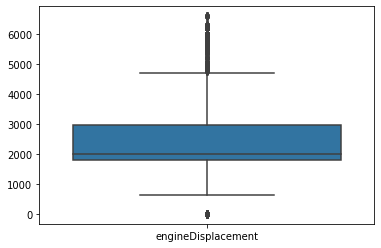

In [26]:
boxes = result[['engineDisplacement']]
ax = sns.boxplot(data=boxes)

Да, двигатель может быть объёмом 0 для электричек, так и 6+ для монстров-джипов. Радует что средний объём двигателя 2.0

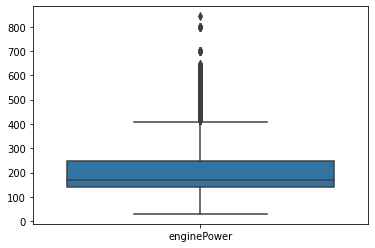

In [27]:
boxes = result[['enginePower']]
ax = sns.boxplot(data=boxes)

Да, есть машины с мощностью более 600лс. И всё это "немецкая тройка", но выделяется мерседес, где ЛС доходят до 800 с "геликами".

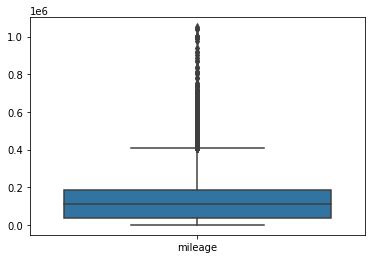

In [28]:
boxes = result[['mileage']]
ax = sns.boxplot(data=boxes)

330 машин с пробегом более 500 000 киллометров, часть из них в тестовом датасете, поэтому оставляем без изменений.

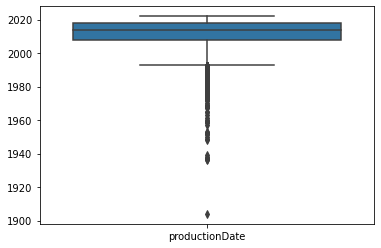

In [29]:
boxes = result[['productionDate']]
ax = sns.boxplot(data=boxes)

В тестовом датасете есть много машин старше 1970 года. Удивляет две машины:
+ мерседес 1936 года с одиним владельцем и 1км пробега
+ кабриолет мерседес 1904 года с 48 000 пробега
Да, антиквариат продают, имеет место быть.

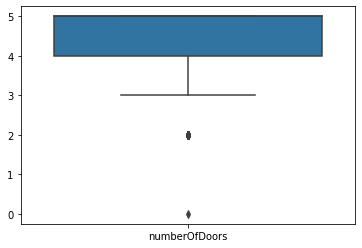

In [30]:
boxes = result[['numberOfDoors']]
ax = sns.boxplot(data=boxes)

Машина с одной дверью это как раз мерседес 1904 года выпуска. Учитывая что это машина выпущенная ещё до Ford Model T, то примем за правду только одну дверь.

### Убираем лишние значения для категориальных колонок. И проверяем значения.

BodyType

In [31]:
result.bodyType.value_counts()

внедорожник      55660
седан            35392
лифтбек           8323
хэтчбек           6960
универсал         3435
минивэн           2370
купе              1882
компактвэн        1638
пикап              779
купе-хардтоп       261
кабриолет          231
фургон             177
родстер            160
микровэн            62
седан-хардтоп       29
лимузин              8
тарга                2
фастбек              1
Name: bodyType, dtype: int64

Множество кузовов, оставим 75% от всех значений, остальное будет Другим

In [32]:
bodyTypeCnt = result['bodyType'].value_counts() #получаем кол-во кузово
allBodyType = result['bodyType'].value_counts() #непосредственно список кузово
percentile = (int(np.percentile(bodyTypeCnt, 75))) #75й персентиль
topBodyType = list(allBodyType[allBodyType>percentile].index) # оставляем в массиве только нужные нам формы

result['bodyType'] = result['bodyType'].apply(lambda x: x if x in topBodyType else 'other') #непосредственно меняем значения в DF

Смотрим что получилось в разрезе типа кузова и цены

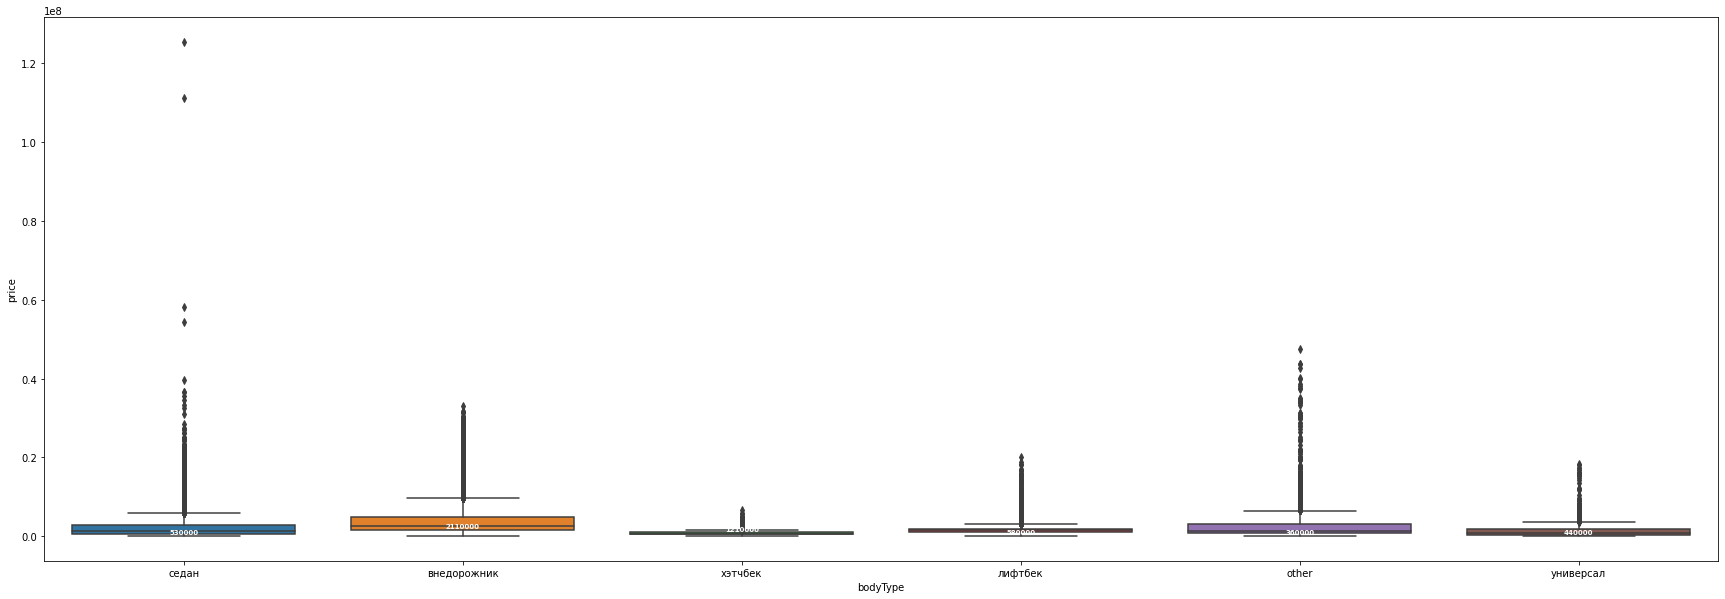

In [33]:
get_box_plot('bodyType')

Внедорожники и седаны ценят больше чем хэтчи, среди седанов есть самые дорогие модели.

Теперь цвета

In [34]:
result.color.value_counts()

black         33617
white         25755
gray          16251
silver        11426
blue          10925
red            5381
brown          5220
green          2706
beige          2073
light blue     1123
purple          674
gold            673
violet          570
orange          503
yellow          436
pink             37
Name: color, dtype: int64

In [35]:
ColorCnt = result['color'].value_counts() #получаем кол-во цветов
allColors = result['color'].value_counts() #непосредственно список цветов
percentile = (int(np.percentile(ColorCnt, 55))) #55й персентиль
topcolor = list(allColors[allColors>percentile].index) # оставляем в массиве только нужные нам цвета

result['color'] = result['color'].apply(lambda x: x if x in topcolor else 'other') #непосредственно меняем значения в DF

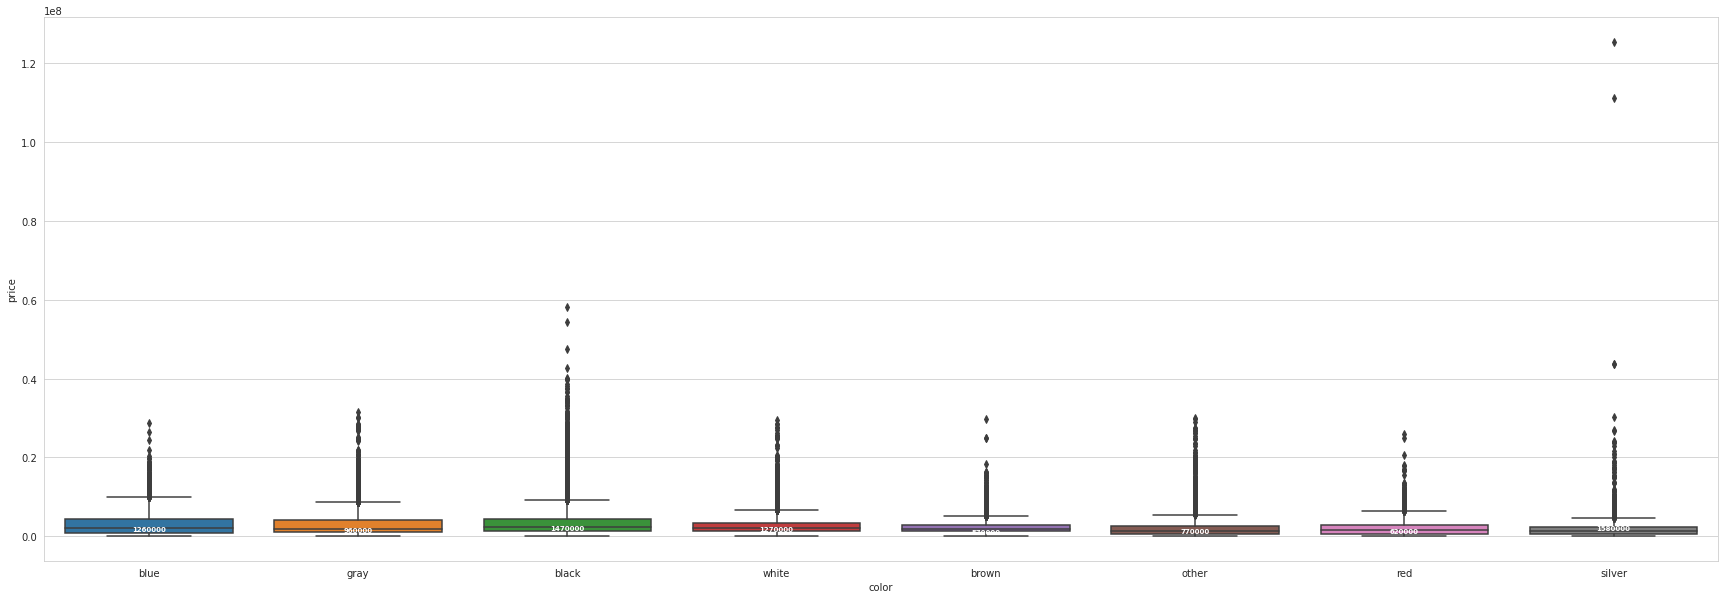

In [36]:
get_box_plot('color')

---


### Теперь посмотрим что по корреляции

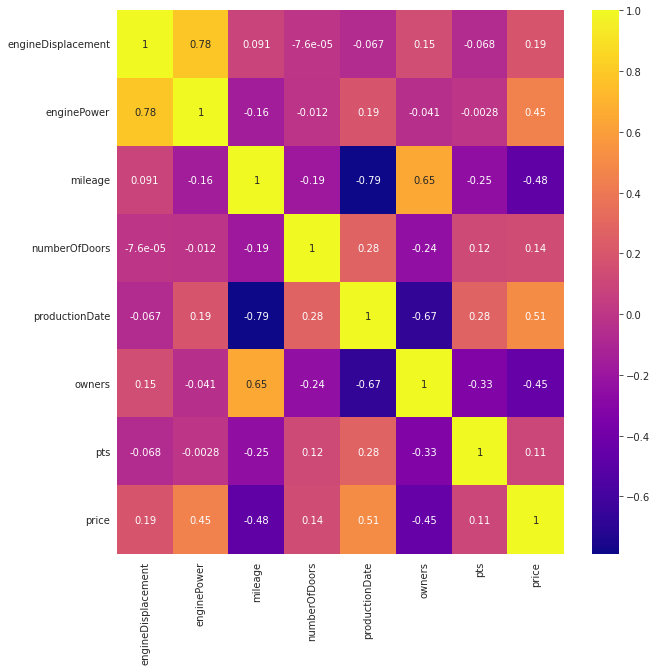

In [37]:
#let see our correlations
fig, ax = plt.subplots(1,1, figsize = (10,10))
ax = sns.heatmap(result.corr(),annot = True, cmap = 'plasma')

Выходит что на цену влияет почти все числовые колонки. Только кол-во дверей не значительно(можно сказать что нет). Остальное очевидные признаки.

Из интересного, пробег больше чем больше владельцев, думаю что связь тут пробег-дата выпуска-кол-во владельцев.

### Сформируем dummy-переменные.

In [38]:
result = pd.get_dummies(data=result, columns=['color', 'vehicleTransmission', 
                                              'steering_wheel', 'bodyType', 
                                              'fuelType', 'gear_type',
                                              'vendor', 'brand'])

In [39]:
result.head(1)

,engineDisplacement,enginePower,mileage,numberOfDoors,productionDate,sell_id,owners,pts,price,color_black,color_blue,color_brown,color_gray,color_other,color_red,color_silver,color_white,vehicleTransmission_AUTOMATIC,vehicleTransmission_MECHANICAL,vehicleTransmission_ROBOT,vehicleTransmission_VARIATOR,steering_wheel_LEFT,steering_wheel_RIGHT,bodyType_other,bodyType_внедорожник,bodyType_лифтбек,bodyType_седан,bodyType_универсал,bodyType_хэтчбек,fuelType_DIESEL,fuelType_ELECTRO,fuelType_GASOLINE,fuelType_HYBRID,fuelType_LPG,gear_type_ALL_WHEEL_DRIVE,gear_type_FORWARD_CONTROL,gear_type_REAR_DRIVE,vendor_AMERICAN,vendor_EUROPEAN,vendor_JAPANESE,brand_AUDI,brand_BMW,brand_HONDA,brand_INFINITI,brand_LEXUS,brand_MERCEDES,brand_MITSUBISHI,brand_NISSAN,brand_SKODA,brand_TOYOTA,brand_VOLKSWAGEN,brand_VOLVO
0,1200.0,105.0,74000,5,2014,1100575026,3,1.0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


После всего посмотрим на корреляцию к цене уже в текстовом виде

In [40]:
s = result.corr().abs().unstack()
s.price.sort_values(ascending=False).head(12)


price                             1.000000
productionDate                    0.507293
mileage                           0.477625
enginePower                       0.453216
owners                            0.451587
gear_type_ALL_WHEEL_DRIVE         0.324315
gear_type_FORWARD_CONTROL         0.289347
bodyType_внедорожник              0.269534
brand_MERCEDES                    0.214951
vehicleTransmission_MECHANICAL    0.208581
vehicleTransmission_AUTOMATIC     0.205393
engineDisplacement                0.192486
dtype: float64

Итого, самая дорогая машина это- свежий полноприводный внедорожник мерседес с мощным двигателем на механике. 

Нормализируем данные и будем приступать

In [41]:
num_cols = ['engineDisplacement','enginePower','mileage','productionDate']
scaler = MinMaxScaler()
result[num_cols] = scaler.fit_transform(result[num_cols].values)

##Feature Engineering? 
*пока не делаем.*

## Начнём строить модели.

Создадим выборки для обучения.

In [42]:
train = result[result['price']>0]
train['price'] = train['price']*0.65

y = train[['price']].copy() #'sell_id', 
X = train.drop(['price', 'sell_id'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Проверяем что всё верно

In [43]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((66147, 50), (16537, 50), (66147, 1), (16537, 1))

Создадим выборку которую надо предсказать

In [44]:
kaggle = result[result['price']==0]
X_kaggle = kaggle.drop(['price', 'sell_id'], axis=1)
X_kaggle.shape

(34686, 50)

## Обучение моделей

### 1. RandomForestRegressor


In [ ]:
from sklearn.ensemble import RandomForestRegressor
rndfrst = RandomForestRegressor(criterion='absolute_error' #используем absolute_error что равно mae
                                , n_estimators= 20
                                , n_jobs= -1
                                , random_state= 42) 

#max_features - Число признаков для выбора расщепления один из самых важных параметров
#max_depth - Максимальная глубина деревьев. Чем меньше тем быстрее, но хуже качество

rndfrst.fit(X_train, y_train)
y_pred = rndfrst.predict(X_test)

print('MAPE тестовой выборки:', mape(y_test, y_pred)) #выводим точность на тестовой выборке
#y_pred = rndfrst.predict(X_kaggle) #подсказываем на тестовой выборке
#results_df = pd.DataFrame(data={'sell_id':kaggle['sell_id'], 'price':y_pred}) #выгружаем в CSV чтобы проверить результат на kaggle
#results_df.to_csv('submission.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


10.5% на тестовой выборке хорошо, даже без подстановки гипперпараметров. Результат на kaggle - 19% ☹
посмотрим что по другим моделям.

### 2. LinearRegression

In [51]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print('MAPE тестовой выборки:', mape(y_test, y_pred)) #выводим точность

#y_pred = reg.predict(X_kaggle) #подсказываем на тестовой выборке
#results_df = pd.DataFrame(data={'sell_id':kaggle['sell_id'], 'price':y_pred.reshape(1, 34686)[0]}) #выгружаем в CSV чтобы проверить результат на kaggle
#results_df.to_csv('submission.csv', index=False)

MAPE тестовой выборки: price    88.701721
dtype: float64


77.09 на тестовой выборке за гранью добра. И, ожидаемо, крайне низкий результат на kaggle-выборке. 

### 3. CatBoost

In [54]:
#попробуем ещё catboost
!pip install catboost

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [55]:
from catboost import CatBoostRegressor
ctbst = CatBoostRegressor()

ctbst.fit(X_train, y_train)
y_pred = ctbst.predict(X_test)

print('MAPE тестовой выборки:', mape(y_test, y_pred)) #выводим точность

#y_pred = ctbst.predict(X_kaggle) #подсказываем на тестовой выборке
#results_df = pd.DataFrame(data={'sell_id':kaggle['sell_id'], 'price':y_pred.reshape(1, 34686)[0]}) #выгружаем в CSV чтобы проверить результат на kaggle
#results_df.to_csv('submission.csv', index=False)

Learning rate set to 0.0794
0:	learn: 1956277.3634654	total: 60ms	remaining: 59.9s
1:	learn: 1844626.5231726	total: 71.3ms	remaining: 35.6s
2:	learn: 1744495.2744739	total: 85.2ms	remaining: 28.3s
3:	learn: 1653190.1024809	total: 96.5ms	remaining: 24s
4:	learn: 1568763.4038006	total: 108ms	remaining: 21.5s
5:	learn: 1492100.1425220	total: 120ms	remaining: 19.8s
6:	learn: 1422400.3618517	total: 131ms	remaining: 18.6s
7:	learn: 1357794.3851608	total: 143ms	remaining: 17.7s
8:	learn: 1300408.7647165	total: 154ms	remaining: 17s
9:	learn: 1249796.4578815	total: 165ms	remaining: 16.4s
10:	learn: 1203566.9567217	total: 177ms	remaining: 15.9s
11:	learn: 1159468.6320946	total: 197ms	remaining: 16.2s
12:	learn: 1119643.7228059	total: 209ms	remaining: 15.8s
13:	learn: 1085605.6770485	total: 225ms	remaining: 15.8s
14:	learn: 1054794.4498274	total: 236ms	remaining: 15.5s
15:	learn: 1023624.3385263	total: 247ms	remaining: 15.2s
16:	learn: 998353.0002851	total: 259ms	remaining: 15s
17:	learn: 972565.

14% тестовой выборке, не будем откидывать в сторону, но не первый выбор. На kaggle результат 20.06787

### 4. ExtraTreesRegressor

In [151]:
from sklearn.ensemble import ExtraTreesRegressor

xtr = ExtraTreesRegressor()
xtr.fit(X_train, y_train)
y_pred = xtr.predict(X_test)

print('MAPE тестовой выборки:', mape(y_test, y_pred)) #выводим точность

y_pred = ctbst.predict(X_kaggle) #подсказываем на тестовой выборке
results_df = pd.DataFrame(data={'sell_id':kaggle['sell_id'], 'price':y_pred}) #выгружаем в CSV чтобы проверить результат на kaggle
results_df.to_csv('submission.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


MAPE тестовой выборки: price    8.773143
dtype: float64


Очень хороший показатель в 8.8! Пока лидер, посмотрим ещё модели обучения, но ExtraTreesRegressor даже с базовыми параметрами показал хороший результат. На kaggle результат 20.06787, меньше чем RandomForestRegressor

### XGBRegressor

In [ ]:
import xgboost as xgb

xgbr = xgb.XGBRegressor()
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

print('MAPE тестовой выборки:', mape(y_test, y_pred)) #выводим точность

[21:03:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


price    20.063578
dtype: float32

20% не так хорошо как хотелось бы.

наш выбор - ExtraTreesRegressor и RandomForestRegressor. Посмотрим что они смогут при подстройке гипперпараметрами.

In [160]:
#начнём с подбора параметров для RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [10, 50, 100]
max_features = ['auto', 'sqrt']
max_depth = [5, 10, 20]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [161]:
random_grid

{'bootstrap': [True, False],
 'max_depth': [5, 10, 20, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 50, 100]}

In [162]:
rf = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, 
                               cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: ignored

In [ ]:
clsf.best_params_

KFOLD

In [168]:
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score

etr_log = ExtraTreesRegressor(random_state=42, n_jobs=-1, verbose=1)

skf = KFold(n_splits=4, random_state=42, shuffle=True)
etr_log_mape_values = []

for train_index, test_index in skf.split(X_train, y_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
    y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
    
    # For training, fit() is used
    etr_log.fit(X_train, np.log(y_train))

    # For MAPE metric (or any other), we need the predictions of the model
    y_pred = np.exp(etr_log.predict(X_test))

    etr_log_mape_value = mape(y_test, y_pred)
    etr_log_mape_values.append(etr_log_mape_value)
    print(etr_log_mape_value)

TRAIN: [    0     2     3 ... 51854 51855 51856] TEST: [    1     4     6 ... 51845 51846 51853]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.4s finished
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


price    13.804276
dtype: float64
TRAIN: [    1     2     3 ... 51853 51854 51856] TEST: [    0     8    11 ... 51849 51850 51855]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.5s finished
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


price    13.691279
dtype: float64
TRAIN: [    0     1     2 ... 51853 51854 51855] TEST: [    3     5    14 ... 51841 51851 51856]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.4s finished
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


price    13.963926
dtype: float64
TRAIN: [    0     1     3 ... 51853 51855 51856] TEST: [    2     9    10 ... 51842 51852 51854]


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s


price    13.75156
dtype: float64


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.4s finished


In [169]:
y_pred = etr_log.predict(X_kaggle) #подсказываем на тестовой выборке
results_df = pd.DataFrame(data={'sell_id':kaggle['sell_id'], 'price':y_pred}) #выгружаем в CSV чтобы проверить результат на kaggle
results_df.to_csv('submission.csv', index=False)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.9s finished
